<a href="https://colab.research.google.com/github/akj0811/RL_Atari/blob/master/DQN_RAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# !apt-get install -y xvfb python-opengl > /dev/null 2>&1
# !pip install gym pyvirtualdisplay > /dev/null 2>&1

from google.colab import drive
drive.mount('/content/drive')

import gym
import numpy as np
import tensorflow
import keras
import matplotlib.pyplot as plt
import pickle
import random

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Using TensorFlow backend.


In [0]:
class ReplayMemory:
    def __init__(self, max_size):
        self.buffer = [None] * max_size
        self.max_size = max_size
        self.index = 0
        self.size = 0

    def append(self, obj):
        self.buffer[self.index] = obj
        self.size = min(self.size + 1, self.max_size)
        self.index = (self.index + 1) % self.max_size

    def sample(self, batch_size):
        indices = random.sample(range(self.size), batch_size)
        return [self.buffer[index] for index in indices]

In [0]:
class Model:
    def __init__(self, frame_size, num_actions):
        self.model = keras.Sequential()
        self.model.add(keras.layers.Dense(128, activation = 'relu', input_shape = (frame_size*128, )))
        self.model.add(keras.layers.Dense(60, activation = 'relu'))
        self.model.add(keras.layers.Dense(num_actions))
        self.model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])
  

In [0]:
class Agent:
    def __init__(self, agent_params):
        self.discount = agent_params['discount']
        self.epsilon = agent_params['epsilon']
        self.num_actions = agent_params['num_actions']
        self.exp_size = agent_params['exp_size']
        self.frame_size = agent_params['frame_size']
        self.merge = agent_params['merge_threshold']
        self.batch_size = agent_params['batch_size']
        self.last_action = None
        self.last_state = None
        self.exp = ReplayMemory(self.exp_size)
        self.frames = np.zeros((1, self.frame_size*128))
        self.target_model = Model(self.frame_size, self.num_actions)
        self.value_model = Model(self.frame_size, self.num_actions)
        self.num_updates = 0
        self.num_steps = 0
        self.num_games = 0
        self.num_merge = 0

    def phi(self, state):
        new = self.frames[:, 128:].copy()
        new = np.concatenate([new, state/255.0], axis = -1)
        self.frames = new.copy()
        return self.frames

    def run(self):
        updates = min(self.batch_size, self.exp.size)
        self.num_updates += updates
        batch = self.exp.sample(updates)

        input = [last_state for last_state, last_action, reward, state, terminal in batch]
        inp = [state for last_state, last_action, reward, state, terminal in batch]
        x_train = np.concatenate(input, axis = 0)
        x_target = np.concatenate(inp, axis = 0)
        y_train = self.value_model.model.predict(x_train)
        y_target = self.target_model.model.predict(x_target)

        for count, memory in enumerate(batch):
            last_state, last_action, reward, state, terminal = memory
            y_train[count][last_action] = reward
            if terminal == 0:
                y_train[count][last_action] += self.discount*np.amax(y_target[count])

        self.value_model.model.fit(x_train, y_train, verbose = 0, epochs = 1)

        if self.num_updates >= self.merge:
            self.merge_model()

    def merge_model(self):
        self.target_model.model.set_weights(self.value_model.model.get_weights())
        self.num_merge += 1
        self.num_updates = 0

    def epsilon_decay(self):
        if self.epsilon > 0.1:
            self.epsilon -= 0.9/1000000

    def choose_action(self, state):
        if np.random.random() < self.epsilon:
            action = np.random.choice(self.num_actions)
        else:
            action = np.argmax(self.value_model.model.predict(state)[0])
    
        self.num_steps += 1
        self.epsilon_decay()
        return action

    def agent_start(self, env_state):
        state = self.phi(env_state)
        self.last_action = self.choose_action(state)
        self.last_state = state
        return self.last_action

    def agent_step(self, reward, env_state):
        state = self.phi(env_state)
        memory = (self.last_state, self.last_action, reward, state, 0)
        self.exp.append(memory)
        self.run()
        self.last_action = self.choose_action(state)
        self.last_state = state
        return self.last_action

    def agent_end(self, reward):
        memory = (self.last_state, self.last_action, reward, np.zeros((1, 512)), 1)
        self.exp.append(memory)
        self.run()
        self.num_games += 1

    def plot(self, states):
        y = np.mean(np.max(self.value_model.model.predict(states), axis = -1))
        return y
    

In [0]:
agent_params = {
    'discount' :0.99,
    'epsilon' : 1.0,
    'num_actions' : 4,
    'exp_size': 200000,
    'frame_size' : 4,
    'merge_threshold' : 100000,
    'batch_size' : 32,
}
agent = Agent(agent_params)
episodes = []
q_value = []
avg_reward = []

In [0]:
env = gym.make('Breakout-ram-v0')

In [0]:
indices = np.random.choice(agent.exp.size, 10000)
test_states = np.zeros((10000, 512))
for count, index in enumerate(indices):
    test_states[count, :] = agent.exp.buffer[index][0]

In [0]:
def train(agent, env):
  
    num_games = 5000
    total = 0
    sum = 0
    for _ in range(1, num_games+1):
        action = agent.agent_start(env.reset().reshape((1, 128)))
        observations, reward, done, info = env.step([action])
        total += reward
        sum += reward

        while not done:
            observations, reward, done, info = env.step([agent.agent_step(reward, observations.reshape((1, 128)))])
            total += reward
            sum += reward

        agent.agent_end(reward)

        if agent.num_games % 20 == 0:
            episodes.append(agent.num_games)
            q_value.append(agent.plot(test_states))
            avg_reward.append(total/20)
            total = 0

        if agent.num_games % 100 == 0:
            print('Games = {}, Steps = {}, Reward = {}'.format(_, agent.num_steps, sum/100))
            sum = 0

        if agent.num_games % 400 == 0:
            with open('/content/drive/My Drive/DQN/episodes0.pkl', 'wb') as f:
                pickle.dump(episodes, f)
            with open('/content/drive/My Drive/DQN/q_value0.pkl', 'wb') as f:
                pickle.dump(q_value, f)
            with open('/content/drive/My Drive/DQN/avg_reward0.pkl', 'wb') as f:
                pickle.dump(avg_reward, f)
            with open('/content/drive/My Drive/DQN/test_states0.pkl', 'wb') as f:
                pickle.dump(test_states, f)
            with open('/content/drive/My Drive/DQN/agent0.pkl', 'wb') as f:
                pickle.dump(agent, f)
        elif agent.num_games % 200 == 0:
            with open('/content/drive/My Drive/DQN/episodes1.pkl', 'wb') as f:
                pickle.dump(episodes, f)
            with open('/content/drive/My Drive/DQN/q_value1.pkl', 'wb') as f:
                pickle.dump(q_value, f)
            with open('/content/drive/My Drive/DQN/avg_reward1.pkl', 'wb') as f:
                pickle.dump(avg_reward, f)
            with open('/content/drive/My Drive/DQN/test_states1.pkl', 'wb') as f:
                pickle.dump(test_states, f)
            with open('/content/drive/My Drive/DQN/agent1.pkl', 'wb') as f:
                pickle.dump(agent, f)

    plt.plot(episodes, q_value)
    plt.plot(episodes, avg_reward)
    plt.show()

In [0]:
train(agent, env)

Games = 100, Steps = 1994838, Reward = 3.04
Games = 200, Steps = 2031246, Reward = 2.81
Games = 300, Steps = 2067292, Reward = 2.21
Games = 400, Steps = 2103371, Reward = 2.59
Games = 500, Steps = 2140660, Reward = 2.82
Games = 600, Steps = 2175408, Reward = 2.62


In [0]:
with open('/content/drive/My Drive/DQN/agent1.pkl', 'rb') as f:
    agent = pickle.load(f)
with open('/content/drive/My Drive/DQN/episodes1.pkl', 'rb') as f:
    episodes = pickle.load(f)
with open('/content/drive/My Drive/DQN/q_value1.pkl', 'rb') as f:
    q_value = pickle.load(f)
with open('/content/drive/My Drive/DQN/avg_reward1.pkl', 'rb') as f:
    avg_reward = pickle.load(f)
with open('/content/drive/My Drive/DQN/test_states1.pkl', 'rb') as f:
    test_states = pickle.load(f)

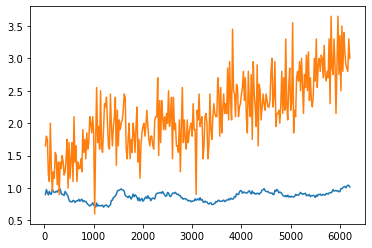

In [27]:
plt.plot(episodes, q_value)
plt.plot(episodes, avg_reward)
plt.show()

In [25]:
print(agent.num_games)

6200
